In [ ]:
#| default_exp data_loader

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from glob import glob
import os
import re
from typing import List, Any, Dict, Union
import warnings

import numpy as np
import pandas as pd

In [ ]:
#| export

from pheno_utils.config import *
from pheno_utils.basic_analysis import *
from pheno_utils.basic_plots import *

In [ ]:
#| export

class DataLoader:
    """
    Class to load multiple tables from a dataset and allows to easily access
    their fields.

    Args:
    
        dataset (str): The name of the dataset to load.
        cohort (str, optional): The name of the cohort within the dataset. Defaults to '10k'.
        base_path (str, optional): The base path where the data is stored. Defaults to '/home/ec2-user/studies'.
        age_sex_dataset (str, optional): The name of the dataset to use for computing age and sex. Defaults to 'Population_Characteristics'.
        skip_dfs (list, optional): A list of tables (or substrings that match to tables) to skip when loading the data. Defaults to [].
        unique_index (bool, optional): Whether to ensure the index of the data is unique. Defaults to False.
        valid_dates (bool, optional): Whether to ensure that all timestamps in the data are valid dates. Defaults to False.
        valid_stage (bool, optional): Whether to ensure that all research stages in the data are valid. Defaults to False.
        flexible_field_search (bool, optional): Whether to allow regex field search. Defaults to False.
        errors (str, optional): Whether to raise an error or issue a warning if missing data is encountered.
            Possible values are 'raise' and 'warn'. Defaults to 'raise'.

    Attributes:
    
        dict (pd.DataFrame): The data dictionary for the dataset, containing information about each field.
        dfs (dict): A dictionary of dataframes, one for each table in the dataset.
        fields (list): A list of all fields in the dataset.
        dataset (str): The name of the dataset being used.
        cohort (str): The name of the cohort being used.
        base_path (str): The base path where the data is stored.
        age_sex_dataset (str): The name of the dataset being used to compute age and sex.
        skip_dfs (list): A list of tables to skip when loading the data.
        unique_index (bool): Whether to ensure the index of the data is unique.
        valid_dates (bool): Whether to ensure that all timestamps in the data are valid dates.
        valid_stage (bool): Whether to ensure that all research stages in the data are valid.
        flexible_field_search (bool): Whether to allow regex field search.
        errors (str): Whether to raise an error or issue a warning if missing data is encountered.
    """

    def __init__(
        self,
        dataset: str,
        cohort: str = '10k',
        base_path: str = DATASETS_PATH,
        age_sex_dataset: str = POPULATION_DATASET,
        skip_dfs: List[str] = [],
        unique_index: bool = False,
        valid_dates: bool = False,
        valid_stage: bool = False,
        flexible_field_search: bool = False,
        errors: str = 'raise'
    ) -> None:
        self.dataset = dataset
        self.cohort = cohort
        self.base_path = base_path
        self.age_sex_dataset = age_sex_dataset
        self.skip_dfs = skip_dfs
        self.unique_index = unique_index
        self.valid_dates = valid_dates
        self.valid_stage = valid_stage
        self.flexible_field_search = flexible_field_search
        self.errors = errors

        self.__load_dictionary__()
        self.__load_dataframes__()
        if self.age_sex_dataset is not None:
            self.__load_age_sex__()

    def load_sample_data(
        self,
        field_name: str,
        participant_id: Union[int, List[int]],
        research_stage: Union[None, str, List[str]] = None,
        array_index: Union[None, int, List[int]] = None,
        load_func: callable = pd.read_parquet,
        concat: bool = True,
        pivot=None, **kwargs
    ) -> Union[pd.DataFrame, None]:
        """
        Load time series or bulk data for sample(s).

        Args:
            field_name (str): The name of the field to load.
            participant_id (str or list): The participant ID or IDs to load data for.
            research_stage (str or list, optional): The research stage or stages to load data for.
            array_index (int or list, optional): The array index or indices to load data for.
            load_func (callable, optional): The function to use to load the data. Defaults to pd.read
            concat (bool, optional): Whether to concatenate the data into a single DataFrame. Automatically ignored if data is not a DataFrame. Defaults to True.
            pivot (str, optional): The name of the field to pivot the data on (if DataFrame). Defaults to None.
        """
        query_str = 'participant_id in @participant_id'
        if not isinstance(participant_id, list):
            participant_id = [participant_id]
        if research_stage is not None:
            if not isinstance(research_stage, list):
                research_stage = [research_stage]
            query_str += ' and research_stage in @research_stage'
        if array_index is not None:
            if not isinstance(array_index, list):
                array_index = [array_index]
            query_str += ' and array_index in @array_index'

        where_field = self.dict.loc[field_name]
        if isinstance(where_field['parent_dataframe'], str):
            field_name = where_field['parent_dataframe']

        sample = self[[field_name] + ['participant_id']].query(query_str)
        missing_participants = np.setdiff1d(participant_id, sample['participant_id'].unique())
        sample = os.path.join(
            self.base_path,
            self.dataset,
            self.cohort) + '/' + sample.iloc[:, 0]

        if len(missing_participants):
            if self.errors == 'raise':
                raise ValueError(f'Missing samples: {missing_participants}')
            elif self.errors == 'warn':
                warnings.warn(f'Missing samples: {missing_participants}')
            if len(sample) == 0:
                return None

        # Load data
        data = []
        for p in sample.unique():
            try:
                data.append(load_func(p, **kwargs))
                if isinstance(data[-1], pd.DataFrame):
                    data[-1].sort_index(inplace=True)
            except Exception as e:
                if self.errors == 'raise':
                    raise e
                elif self.errors == 'warn':
                    warnings.warn(f'Error loading {p}: {e}')

        # Format the final result
        if concat and isinstance(data[0], pd.DataFrame):
            data = pd.concat(data, axis=0)
        if pivot is not None and isinstance(data, pd.DataFrame):
            if pivot in data.index.names:
                data = data.reset_index(pivot)
            data = data.pivot(columns=pivot)

        return data

    def __repr__(self):
        """
        Return string representation of object

        Returns:
            str: String representation of object
        """
        return self.__str__()

    def __str__(self):
        """
        Return string representation of object

        Returns:
            str: String representation of object
        """
        return f'DataLoader for {self.dataset} with' +\
            f'\n{len(self.fields)} fields\n{len(self.dfs)} tables: {list(self.dfs.keys())}'

    def __getitem__(self, fields: Union[str,List[str]]):
        """
        Return data for the specified fields from all tables

        Args:
            fields (Union[str, List[str]]): Fields to return

        Returns:
            pd.DataFrame: Data for the specified fields from all tables
        """
        return self.get(fields)

    def get(self, fields: Union[str,List[str]], flexible: bool=None):
        """
        Return data for the specified fields from all tables

        Args:
            fields (List[str]): Fields to return
            flexible (bool, optional): Whether to use fuzzy matching to find fields. Defaults to None, which uses the DataLoader's flexible_field_search attribute.

        Returns:
            pd.DataFrame: Data for the specified fields from all tables
        """
        if flexible is None:
            flexible = self.flexible_field_search
        if isinstance(fields, str):
            fields = [fields]

        data = pd.DataFrame()
        for df in self.dfs.values():
            if flexible:
                # use fuzzy matching including regex to find fields
                fields_in_col = np.unique([col for f in fields for col in df.columns if re.search(f, col)])
            else:
                fields_in_col = df.columns.intersection(fields).difference(data.columns)
            if len(fields_in_col):
                data = self.__concat__(data, df[fields_in_col])

            fields_in_index = np.setdiff1d(np.intersect1d(df.index.names, fields), data.columns)
            if len(fields_in_index):
                data = self.__concat__(
                    data,
                    pd.DataFrame(df.index.get_level_values(fields_in_index), index=df.index))

        if len(data):
            data = data.loc[:, ~data.columns.duplicated()]

        not_found = np.setdiff1d(fields, data.columns)
        if len(not_found) and not flexible:
            if self.errors == 'raise':
                raise KeyError(f'Fields not found: {not_found}')
            elif self.errors == 'warn':
                warnings.warn(f'Fields not found: {not_found}')

        return data

    def __concat__(self, df1, df2):
        if df1.empty:
            return df2
        if df2.empty:
            return df1
        return df1.join(df2, how='outer')

    def __load_age_sex__(self) -> None:
        """
        Add sex and compute age from birth date.
        """
        age_path = os.path.join(
            self.base_path,
            self.age_sex_dataset,
            self.cohort,
            'events.parquet')
        align_df = self.dfs[list(self.dfs)[0]]

        if ('research_stage' in align_df.columns) or ('research_stage' in align_df.index.names):
            age_df = pd.read_parquet(age_path)
            self.dfs['age_sex'] = align_df.join(
                age_df[['age_at_research_stage', 'sex']].droplevel('array_index'))\
                .rename(columns={'age_at_research_stage': 'age'})[['age', 'sex']]
        else:
            # init an empty df
            self.dfs['age_sex'] = pd.DataFrame(index=align_df.index).assign(age=np.nan, sex=np.nan)

        self.fields += ['age', 'sex']
        ind = self.dfs['age_sex'].isnull().any(axis=1)
        if not ind.any():  # no missing values
            return

        # fill in missing values by computing age from birth date
        date_cols = np.array(['collection_timestamp', 'collection_date', 'sequencing_date'])
        date = date_cols[np.isin(date_cols, align_df.columns)][0]  # prefer first match

        ind &= align_df[date].notnull()
        if not ind.any():
            return

        age_df = pd.read_parquet(age_path.replace('events', 'population'))
        age_df['birth_date'] = pd.to_datetime(
            age_df['year_of_birth'].astype(str) + '-' + age_df['month_of_birth'].astype(str))

        # trying a workaround for a pandas deprecation warning
        age_sex = self.dfs['age_sex']
        missing_age_sex = align_df.loc[ind, [date]].join(age_df[['sex', 'birth_date']])\
            .assign(age=lambda x: ((x[date].dt.date - x['birth_date'].dt.date).dt.days / 365.25).round(1))\
            [['age', 'sex']]
        age_sex = age_sex.join(missing_age_sex, rsuffix='_miss')
        age_sex['age'] = age_sex['age'].fillna(age_sex['age_miss'])
        age_sex['sex'] = age_sex['sex'].fillna(age_sex['sex_miss'])
        self.dfs['age_sex'] = age_sex[['age', 'sex']]

    def __load_dataframes__(self) -> None:
        """
        Load all tables in the dataset dictionary.
        """
        self.dfs = {}
        self.fields = set()
        for relative_location in self.dict['relative_location'].dropna().unique():
            if any([pattern in relative_location for pattern in self.skip_dfs]):
                print(f'Skipping {relative_location}')
                continue
            df = self.__load_one_dataframe__(relative_location)
            if df is None:
                continue
            self.dfs[relative_location.split('.')[0]] = df
            if not df.index.is_unique:
                print('Warning: index is not unique for', relative_location)
            self.fields |= set(self.dfs[relative_location.split('.')[0]].columns.tolist())
        self.fields = sorted(list(self.fields))

    def __load_one_dataframe__(self, relative_location: str) -> pd.DataFrame:
        """
        Load one dataframe.

        Args:
            relative_location (str): the location of the dataframe

        Returns:
            pd.DataFrame: the loaded dataframe
        """
        df_path = os.path.join(
            self.base_path,
            self.dataset,
            self.cohort,
            relative_location)
        try:
            data =  pd.read_parquet(df_path)
        except Exception as err:
            if self.errors == 'raise':
                raise err
            if self.errors == 'warn':
                warnings.warn(f'Error loading {df_path}:\n{err}')
            return None

        # set the order of columns according to the dictionary
        dict_columns = self.dict.index.intersection(data.columns)
        other_columns = data.columns.difference(self.dict.index)
        assert (len(dict_columns) + len(other_columns)) == len(data.columns), "something isn't right"
        data = data[dict_columns.tolist() + other_columns.tolist()]

        before = len(data)
        if self.unique_index:
            data = data.loc[~data.index.duplicated()]
        if self.valid_dates:
            data = data.loc[data.select_dtypes(include=['datetime64[ns]']).notnull().any(axis=1)]
        if self.valid_stage:
            data = data.loc[data.index.get_level_values('research_stage').notnull()]
        after = len(data)
        if before > after:
            print(f'Filtered {before - after} rows')

        return data

    def __load_dictionary__(self) -> None:
        """
        Load dataset dictionary.
        """
        self.dict = pd.read_csv(self.__get_file_path__(self.dataset, 'csv'))\
            .set_index('tabular_field_name')
        self.fields = self.dict.index.tolist()

    def __get_file_path__(self, dataset: str, extension: str) -> str:
        """
        Get the file path for a dataset and an extension.

        Args:
            dataset (str): the name of the dataset
            extension (str): the extension of the file

        Returns:
            str: the path to the file
        """
        path = os.path.join(self.base_path, dataset, self.cohort, '*.' + extension)
        if path.startswith('s3://'):
           return path
        return glob(path)[0]
    
    def describe_field(self, fields: Union[str,List[str]], return_summary: bool=False):
        """
        Display a summary dataframe for the specified fields from all tables

        Args:
            fields (List[str]): Fields to return
            return_summary (Bool): whether to return the summary dataframe
        
        Returns:
            pd.DataFrame: Data for the specified fields from all tables
        """
        if isinstance(fields, str):
            fields = [fields]
            
        summary_df = pd.concat([self.dict.loc[fields,:].T,
                                custom_describe(self[fields])])
        display(summary_df)
        if return_summary:
            return summary_df

Use the dataset name to load the dataset. It may contain multiple tables. Age / sex will be added to the data by default. The default `base_path` is set to work on the research platform.

In [ ]:
dl = DataLoader('Fundus', base_path='examples/', errors='warn')
dl

DataLoader for Fundus with
78 fields
2 tables: ['fundus', 'age_sex']

The DataLoader class contains several usefull attributes

The data dictionary of the dataset displays the description of each field.

In [ ]:
dl.dict.head(3)

,field_string,description_string,parent_dataframe,relative_location,value_type,units,sampling_rate,item_type,array,cohorts,data_type,debut,pandas_dtype
tabular_field_name,,,,,,,,,,,,,
fundus_image_left,Fundus image (left),Fundus image (left),NaN,fundus.parquet,Text,None,NaN,Bulk,Single,10K,image,2021-02-17,string
fundus_image_right,Fundus image (right),Fundus image (right),NaN,fundus.parquet,Text,None,NaN,Bulk,Single,10K,image,2021-02-17,string
collection_date,Collection date (YYYY-MM-DD),Collection date (YYYY-MM-DD),NaN,fundus.parquet,Date,Time,NaN,Data,Single,10K,tabular,2021-02-17,datetime64[ns]


In [ ]:
dl.dfs['fundus'].head(3)

,,,,fundus_image_left,fundus_image_right,collection_date,artery_average_width_left,artery_average_width_right,artery_distance_tortuosity_left,artery_distance_tortuosity_right,artery_fractal_dimension_left,artery_fractal_dimension_right,artery_squared_curvature_tortuosity_left,...,vein_fractal_dimension_left,vein_fractal_dimension_right,vein_squared_curvature_tortuosity_left,vein_squared_curvature_tortuosity_right,vein_tortuosity_density_left,vein_tortuosity_density_right,vein_vessel_density_left,vein_vessel_density_right,vessel_density_left,vessel_density_right
participant_id,cohort,research_stage,array_index,,,,,,,,,,,,,,,,,,,,,
0,10k,00_00_visit,0,/path/to/file,/path/to/file,2022-11-16,18430.284751,19038.547771,3.668175,3.271147,1.355673,1.343602,40.648267,...,1.410553,1.403108,14.208195,6.098432,0.700187,0.698546,0.046645,0.045864,0.080377,0.078671
1,10k,00_00_visit,0,/path/to/file,/path/to/file,2022-06-30,17315.398780,19099.489575,2.095461,1.634782,1.368933,1.363413,24.253169,...,1.387527,1.332864,8.999069,8.702682,0.740806,0.708911,0.037896,0.046853,0.074197,0.064578
2,10k,00_00_visit,0,/path/to/file,/path/to/file,2021-10-05,15375.866993,19855.576862,2.776472,2.747015,1.360404,1.362699,9.742353,...,1.411881,1.408791,13.119227,9.936669,0.627281,0.675100,0.053022,0.048063,0.079515,0.082102


All availbale fields (columns) in all tables can be listed.

In [ ]:
dl.fields[:5]

['artery_average_width_left',
 'artery_average_width_right',
 'artery_distance_tortuosity_left',
 'artery_distance_tortuosity_right',
 'artery_fractal_dimension_left']

Access any of the fields (e.g., `vein_average_width_right`, `age`) or indices (e.g., `research_stage`) from any of the tables via the data loader API.

In [ ]:
dl[['research_stage', 'vein_average_width_right', 'age', 'sex']]

,,,,vein_average_width_right,research_stage,age,sex
participant_id,cohort,research_stage,array_index,,,,
0,10k,00_00_visit,0,18436.428634,00_00_visit,43.5,0
1,10k,00_00_visit,0,18888.160314,00_00_visit,53.7,1
2,10k,00_00_visit,0,19013.865043,00_00_visit,26.2,0
3,10k,00_00_visit,0,18809.012493,00_00_visit,44.6,1
4,10k,00_00_visit,0,19428.986690,00_00_visit,50.3,0


Access time series or bulk data that is stored separately for each sample via the data loader API. In the following example, the data loader retrieves the relative path of each sample's bulk file from the main table (where it is stored in the field `fundus_image_left`), converts it to an absolute path, and loads the file. This is repeated for 3 samples and returned as a list. In the case of parquet DataFrames, there is no need to define the `load_func` and multiple DFs are concatenated by deafult.

In [ ]:
#| hide

dl.dfs['fundus']['fundus_image_left'] = [f'M0/images/fundus_{i}.png' for i in range(5)]

[None, None]

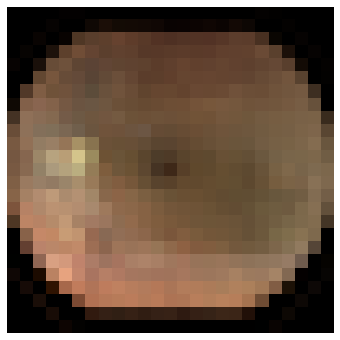

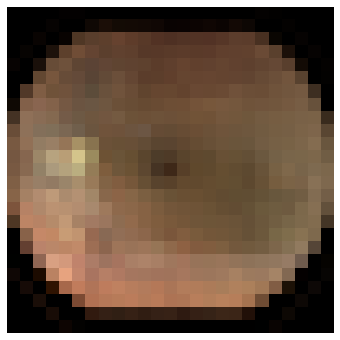

In [ ]:
dl.load_sample_data('fundus_image_left', [0, 1], load_func=show_fundus)

You can perform flexible field search (with regex support), when initializing the DataLoader as follows:

In [ ]:
dl = DataLoader('Fundus', base_path='examples/', flexible_field_search=True)

For example, the following command will search for any field starting with "fractal".

In [ ]:
dl['^fractal']

,,,,fractal_dimension_left,fractal_dimension_right
participant_id,cohort,research_stage,array_index,,
0,10k,00_00_visit,0,1.564989,1.520885
1,10k,00_00_visit,0,1.542311,1.534158
2,10k,00_00_visit,0,1.482051,1.545097
3,10k,00_00_visit,0,1.548773,1.539352
4,10k,00_00_visit,0,1.554922,1.557029


You can summarize a field or set of fields by the following command

In [ ]:
dl.describe_field(['fundus_image_right', 'collection_date'])

,fundus_image_right,collection_date
field_string,Fundus image (right),Collection date (YYYY-MM-DD)
description_string,Fundus image (right),Collection date (YYYY-MM-DD)
parent_dataframe,NaN,NaN
relative_location,fundus.parquet,fundus.parquet
value_type,Text,Date
units,None,Time
sampling_rate,NaN,NaN
item_type,Bulk,Data
array,Single,Single
cohorts,10K,10K


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()